# **INIT**

In [39]:
!pip install shap lime eli5

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sbs

sbs.set_theme()

# %matplotlib qt
%matplotlib inline

# **Diabetes Prediction**




In [42]:
df = pd.read_csv("/content/drive/MyDrive/diabetes.csv")
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [44]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

We can see that some values are outright outliers; like the Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI are just 0. Which doesn't seems a possible value.

In [45]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

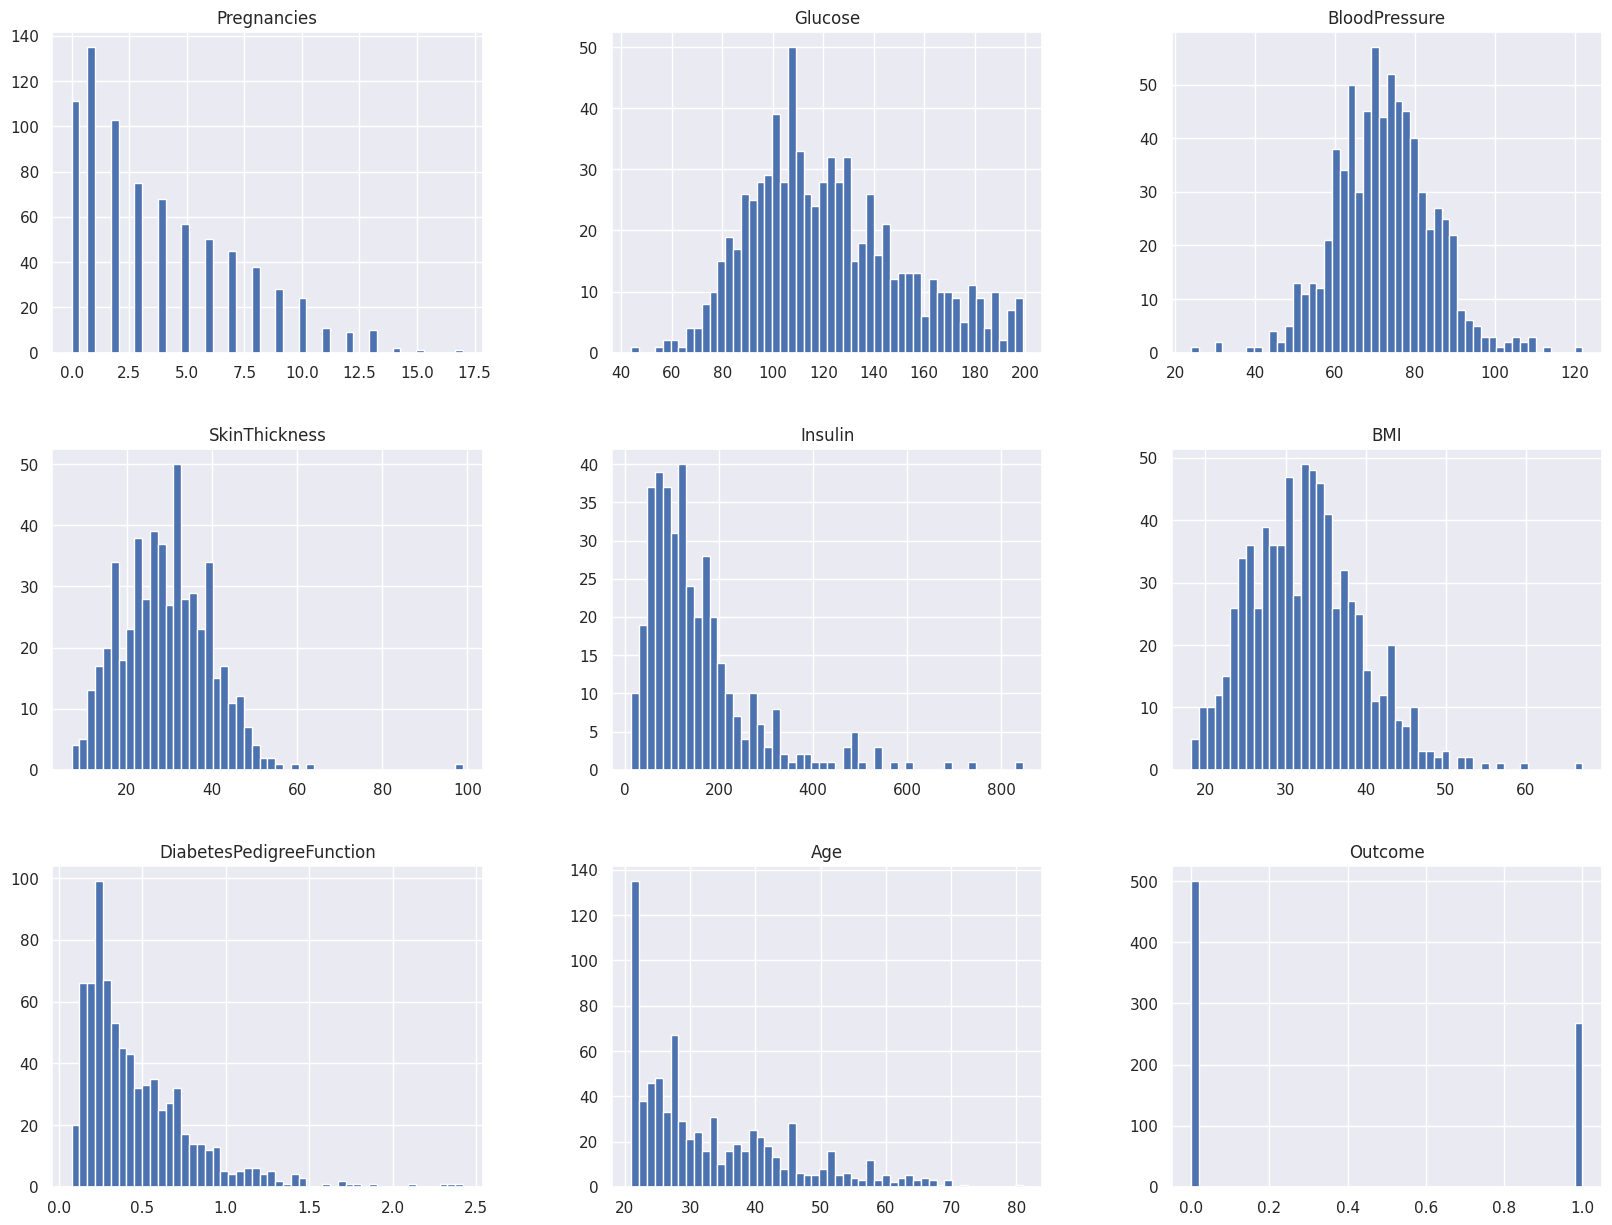

In [46]:
_ = df.hist(bins=50, figsize=(20, 15))

Let's see how many diabetic and healthy persons we do have.

<Axes: >

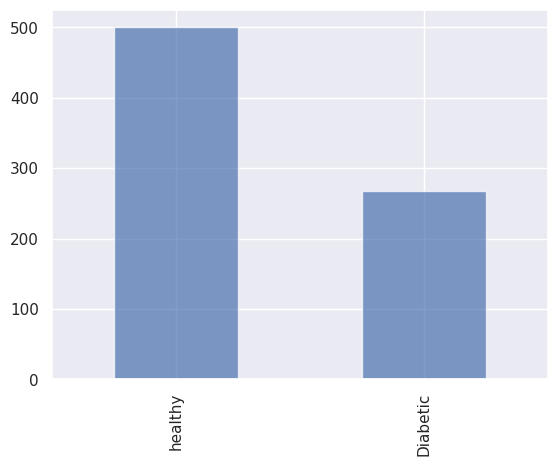

In [47]:
Healthy =  df[ df['Outcome'] == 0 ]
Diabetic = df[ df['Outcome'] == 1 ]

h_diab = pd.Series({'healthy':Healthy.shape[0],
            'Diabetic':Diabetic.shape[0]})
h_diab.plot.bar(alpha=0.7)

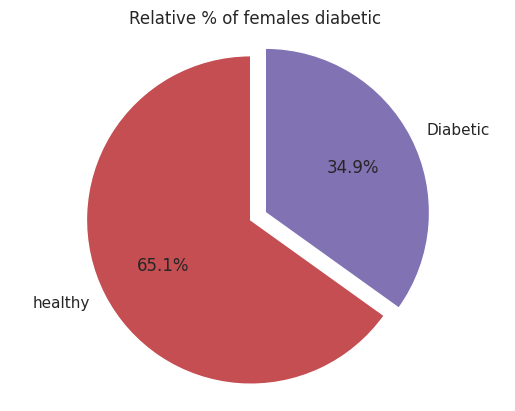

In [48]:
h_diab.plot.pie(startangle=90,
                explode=[0, 0.1],
                autopct='%1.1f%%',
                colors=['C3', 'C4'])
plt.title('Relative % of females diabetic ')
plt.ylabel('')
_ = plt.axis('equal')

### Taking a look at null values

In [49]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [50]:
df.pivot_table(index=['Outcome'] )

Age        BMI  BloodPressure  DiabetesPedigreeFunction  \
Outcome                                                                  
0        31.190000  30.859674      70.877339                  0.429734   
1        37.067164  35.406767      75.321429                  0.550500   

            Glucose     Insulin  Pregnancies  SkinThickness  
Outcome                                                      
0        110.643863  130.287879     3.298000      27.235457  
1        142.319549  206.846154     4.865672      33.000000

We can replace this null values with median values with the appropriate values for the given outcome.

<mark>If the distribution is not symmetrical, it makes sense to use a median instead of the mean. B/c it represents the series better as it will be less affected by median outliers.</mark>

In [51]:
def replace_null_values(df):
    for col in df.columns:
        df.loc[(df['Outcome']==0) & (df[col].isnull()), col] = df[df['Outcome'] == 0][col].median()
        df.loc[(df['Outcome']==1) & (df[col].isnull()), col] = df[ df['Outcome'] == 1][col].median()
    print(df.isnull().sum())

replace_null_values(df)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### Feature Engineering

In [52]:
def create_new_bmi(df):
    new_cat = "NEW_BMI_CAT"
    df.loc[(df['BMI'] < 18.5), new_cat] = "underweight"
    df.loc[(df['BMI'] > 18.5) & (df['BMI'] < 25), new_cat] = "normal"
    df.loc[(df['BMI'] > 24) & (df['BMI'] < 30), new_cat] =  "overweight"
    df.loc[(df['BMI'] > 30) & (df['BMI']< 40), new_cat] = "obese"
    df.drop('BMI', axis=1, inplace=True)
    df[new_cat] = df[new_cat].astype('category')

def create_new_glucose(df):
    new_cat = "NEW_GLUCOSE_CAT"
    df.loc[(df['Glucose'] < 70), new_cat] = "low"
    df.loc[(df['Glucose'] > 70) & (df['Glucose'] < 99), new_cat] = "normal"
    df.loc[(df['Glucose'] > 99) & (df['Glucose'] < 126), new_cat] = "high"
    df.loc[(df['Glucose'] > 126) & (df['Glucose'] < 200), new_cat] = "very_high"
    df[new_cat] = df[new_cat].astype('category')


def create_new_skinthickness(df):
    new_cat = "NEW_SKIN_THICKNESS"
    df.loc[df['SkinThickness'] < 30, new_cat] = "normal"
    df.loc[df['SkinThickness'] >= 70, new_cat] = "highfat"
    df[new_cat] = df[new_cat].astype('category')

def create_new_pregnancies(df):
    new_cat = "NEW_PREGNANCIES"
    df.loc[df['Pregnancies'] == 0, new_cat] = "no_pregnancies"
    df.loc[(df['Pregnancies'] > 0) & df['Pregnancies'] <= 4, new_cat] = "std_pregnancies"
    df.loc[(df['Pregnancies'] > 4), new_cat] = "over_pregnancies"
    df[new_cat] = df[new_cat].astype('category')

def create_circulation_level(df):
    new_cat = "NEW_CIRCULATION_LEVEL"
    df.loc[(df['SkinThickness'] < 30) & (df['BloodPressure'] < 80), new_cat] = "normal"
    df.loc[(df['SkinThickness'] > 30) & (df['BloodPressure']>= 80), new_cat] = "high_risk"
    df.loc[((df['SkinThickness']< 30) & (df['BloodPressure'] >=80)) | ((df['SkinThickness']> 30) & (df['BloodPressure'] <80)), new_cat] = "medium_risk"
    df[new_cat] = df[new_cat].astype('category')
    df.drop('SkinThickness', axis=1, inplace=True)

def create_other_features(df):
    df['PRE_AGE_CAT'] = df['Age'] * df['Pregnancies']
    df['INSULIN_GLUCOSE_CAT'] = df['Insulin'] * df['Glucose']
    df.drop('Pregnancies', axis=1, inplace=True)
    df.drop('Glucose', axis=1, inplace=True)

create_new_bmi(df)
create_new_glucose(df)
create_new_pregnancies(df)
create_new_skinthickness(df)
create_circulation_level(df)
create_other_features(df)
df

BloodPressure  Insulin  DiabetesPedigreeFunction  Age  Outcome  \
0             72.0    169.5                     0.627   50        1   
1             66.0    102.5                     0.351   31        0   
2             64.0    169.5                     0.672   32        1   
3             66.0     94.0                     0.167   21        0   
4             40.0    168.0                     2.288   33        1   
..             ...      ...                       ...  ...      ...   
763           76.0    180.0                     0.171   63        0   
764           70.0    102.5                     0.340   27        0   
765           72.0    112.0                     0.245   30        0   
766           60.0    169.5                     0.349   47        1   
767           70.0    102.5                     0.315   23        0   

    NEW_BMI_CAT NEW_GLUCOSE_CAT   NEW_PREGNANCIES NEW_SKIN_THICKNESS  \
0         obese       very_high  over_pregnancies                NaN   
1    overweight          normal   std_pregnancies             normal   
2        normal       very_high  over_pregnancies                NaN   
3    overweight          normal   std_pregnancies             normal   
4           NaN       very_high   std_pregnancies                NaN   
..          ...             ...               ...                ...   
763       obese            high  over_pregnancies                NaN   
764       obese            high   std_pregnancies             normal   
765  overweight            high  over_pregnancies             normal   
766       obese             NaN   std_pregnancies                NaN   
767       obese          normal   std_pregnancies                NaN   

    NEW_CIRCULATION_LEVEL  PRE_AGE_CAT  INSULIN_GLUCOSE_CAT  
0             medium_risk          300              25086.0  
1                  normal           31               8712.5  
2             medium_risk          256              31018.5  
3                  normal           21               8366.0  
4             medium_risk            0              23016.0  
..                    ...          ...                  ...  
763           medium_risk          630              18180.0  
764                normal           54              12505.0  
765                normal          150              13552.0  
766           medium_risk           47              21357.0  
767           medium_risk           23               9532.5  

[768 rows x 12 columns]

### Label Encoding
Doing Label encoding only for `Outcome` column.

In [53]:
df['NEW_CIRCULATION_LEVEL'].dtype.name == 'category'

True

In [54]:
len(df['NEW_CIRCULATION_LEVEL'].unique())

4

In [55]:
label_encoder = preprocessing.LabelEncoder()
df['Outcome'] = label_encoder.fit_transform(df['Outcome'])

### One-Hot Encoding
We'll do One-Hot encoding for categorical cols.

In [56]:
categ_cols = [col for col in df.columns if df[col].dtype.name == 'category']
print(categ_cols)

['NEW_BMI_CAT', 'NEW_GLUCOSE_CAT', 'NEW_PREGNANCIES', 'NEW_SKIN_THICKNESS', 'NEW_CIRCULATION_LEVEL']


In [57]:
def one_hot_encoder(df, columns):
    df_dummy = df.copy()
    df_dummy = pd.get_dummies(df, columns=columns, drop_first=True)
    return df_dummy

result = one_hot_encoder(df, categ_cols)
result

BloodPressure  Insulin  DiabetesPedigreeFunction  Age  Outcome  \
0             72.0    169.5                     0.627   50        1   
1             66.0    102.5                     0.351   31        0   
2             64.0    169.5                     0.672   32        1   
3             66.0     94.0                     0.167   21        0   
4             40.0    168.0                     2.288   33        1   
..             ...      ...                       ...  ...      ...   
763           76.0    180.0                     0.171   63        0   
764           70.0    102.5                     0.340   27        0   
765           72.0    112.0                     0.245   30        0   
766           60.0    169.5                     0.349   47        1   
767           70.0    102.5                     0.315   23        0   

     PRE_AGE_CAT  INSULIN_GLUCOSE_CAT  NEW_BMI_CAT_obese  \
0            300              25086.0                  1   
1             31               8712.5                  0   
2            256              31018.5                  0   
3             21               8366.0                  0   
4              0              23016.0                  0   
..           ...                  ...                ...   
763          630              18180.0                  1   
764           54              12505.0                  1   
765          150              13552.0                  0   
766           47              21357.0                  1   
767           23               9532.5                  1   

     NEW_BMI_CAT_overweight  NEW_BMI_CAT_underweight  NEW_GLUCOSE_CAT_low  \
0                         0                        0                    0   
1                         1                        0                    0   
2                         0                        0                    0   
3                         1                        0                    0   
4                         0                        0                    0   
..                      ...                      ...                  ...   
763                       0                        0                    0   
764                       0                        0                    0   
765                       1                        0                    0   
766                       0                        0                    0   
767                       0                        0                    0   

     NEW_GLUCOSE_CAT_normal  NEW_GLUCOSE_CAT_very_high  \
0                         0                          1   
1                         1                          0   
2                         0                          1   
3                         1                          0   
4                         0                          1   
..                      ...                        ...   
763                       0                          0   
764                       0                          0   
765                       0                          0   
766                       0                          0   
767                       1                          0   

     NEW_PREGNANCIES_std_pregnancies  NEW_SKIN_THICKNESS_normal  \
0                                  0                          0   
1                                  1                          1   
2                                  0                          0   
3                                  1                          1   
4                                  1                          0   
..                               ...                        ...   
763                                0                          0   
764                                1                          1   
765                                0                          1   
766                                1                          0   
767                                1                          0   

    

# **Model Training**


In [58]:
from sklearn.model_selection import train_test_split

X = result.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since the consequences of detection False Negatives are high; the task should be **Recall centric**.

### Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [400, 500, 600],
              'max_leaf_nodes': [14, 15, 16]}
random_forest = RandomForestClassifier(n_jobs=-1)

grid_search_rf = GridSearchCV(random_forest,
                              param_grid=param_grid,
                              cv=3,
                              scoring='recall',
                              return_train_score=True, verbose = 1)
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'max_leaf_nodes': 14, 'n_estimators': 400}

In [60]:
from sklearn.metrics import classification_report, recall_score, roc_auc_score
print(classification_report(y_test, grid_search_rf.predict(X_test)))
print(recall_score(y_test, grid_search_rf.predict(X_test)))
print(roc_auc_score(y_test, grid_search_rf.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        99
           1       0.76      0.82      0.79        55

    accuracy                           0.84       154
   macro avg       0.83      0.84      0.83       154
weighted avg       0.85      0.84      0.85       154

0.8181818181818182
0.9248852157943067


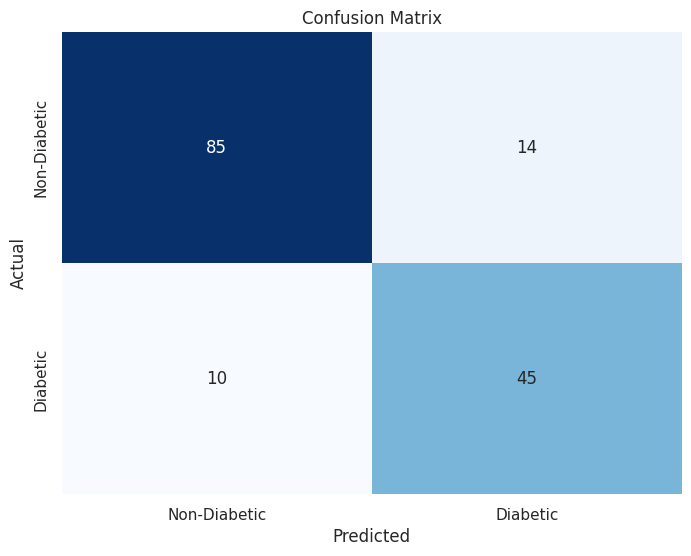

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, grid_search_rf.predict(X_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **SHAP**

In [62]:
features = list(X_train)
feature_importances = grid_search_rf.best_estimator_.feature_importances_
importances = pd.DataFrame(index=features)
importances['importance'] = feature_importances
importances['rank'] = importances['importance'].rank(ascending=False).values
importances.sort_values('rank').head()

importance  rank
Insulin                      0.334048   1.0
INSULIN_GLUCOSE_CAT          0.302588   2.0
Age                          0.071679   3.0
NEW_SKIN_THICKNESS_normal    0.068379   4.0
NEW_GLUCOSE_CAT_very_high    0.059107   5.0

In [63]:
import shap
# Get list of features
features = list(X_train)

# Train explainer on Training set
explainer = shap.TreeExplainer(grid_search_rf.best_estimator_, X_train.sample(100))

# Get Shap values (extended version has other data returned as well as shap values)
shapley_values_train_extended = explainer(X_train, check_additivity=False)
shapley_values_train = shapley_values_train_extended.values[:,:,1]
shapley_values_test_extended = explainer(X_test, check_additivity=False)
shapley_values_test = shapley_values_test_extended.values[:,:,1]

# Calculate mean Shapley value for each feature in trainign set
importances['mean_shapley_values'] = np.mean(shapley_values_train, axis=0)

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
importances['mean_abs_shapley_values'] = np.mean(
    np.abs(shapley_values_train),axis=0)

 93%|=================== | 1145/1228 [00:15<00:01]       

In [64]:
importances.sort_values(by='importance', ascending=False).head()
importances.head(10)

importance  rank  mean_shapley_values  \
BloodPressure               0.017373   9.0         7.059911e-05   
Insulin                     0.334048   1.0         2.901314e-02   
DiabetesPedigreeFunction    0.029811   8.0         1.958439e-03   
Age                         0.071679   3.0         2.051532e-03   
PRE_AGE_CAT                 0.037593   7.0         2.903210e-03   
INSULIN_GLUCOSE_CAT         0.302588   2.0         2.157168e-02   
NEW_BMI_CAT_obese           0.004141  14.0         3.076133e-04   
NEW_BMI_CAT_overweight      0.007060  12.0         9.896628e-04   
NEW_BMI_CAT_underweight     0.000000  16.0         0.000000e+00   
NEW_GLUCOSE_CAT_low         0.000057  15.0         2.122061e-07   

                          mean_abs_shapley_values  
BloodPressure                            0.004502  
Insulin                                  0.116232  
DiabetesPedigreeFunction                 0.009012  
Age                                      0.033904  
PRE_AGE_CAT                              0.012089  
INSULIN_GLUCOSE_CAT                      0.116256  
NEW_BMI_CAT_obese                        0.001861  
NEW_BMI_CAT_overweight                   0.003834  
NEW_BMI_CAT_underweight                  0.000000  
NEW_GLUCOSE_CAT_low                      0.000003

In [65]:
# Get top 10 features
importance_top_10 = \
    importances.sort_values(by='importance', ascending=False).head(10).index
shapley_top_10 = \
    importances.sort_values(
    by='mean_abs_shapley_values', ascending=False).head(10).index

# Add to DataFrame
top_10_features = pd.DataFrame()
top_10_features['importances'] = importance_top_10.values
top_10_features['Shapley'] = shapley_top_10.values

# Display
top_10_features

importances                       Shapley
0                       Insulin           INSULIN_GLUCOSE_CAT
1           INSULIN_GLUCOSE_CAT                       Insulin
2                           Age     NEW_SKIN_THICKNESS_normal
3     NEW_SKIN_THICKNESS_normal                           Age
4     NEW_GLUCOSE_CAT_very_high     NEW_GLUCOSE_CAT_very_high
5  NEW_CIRCULATION_LEVEL_normal  NEW_CIRCULATION_LEVEL_normal
6                   PRE_AGE_CAT                   PRE_AGE_CAT
7      DiabetesPedigreeFunction      DiabetesPedigreeFunction
8                 BloodPressure                 BloodPressure
9        NEW_GLUCOSE_CAT_normal        NEW_BMI_CAT_overweight

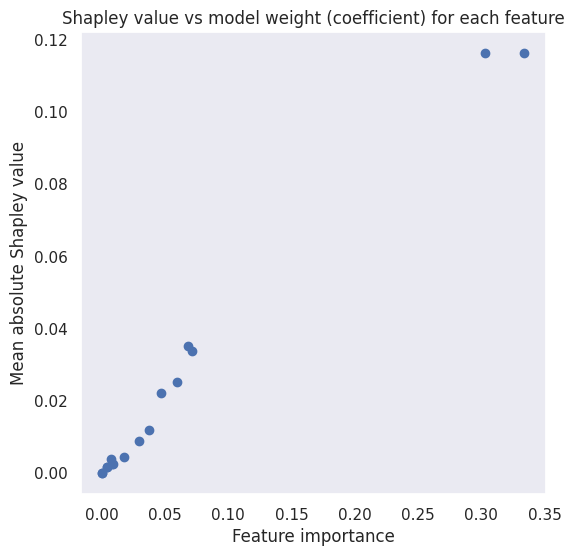

In [66]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# Plot points
x = importances['importance']
y = importances['mean_abs_shapley_values']
ax.scatter(x, y)
ax.set_title('Shapley value vs model weight (coefficient) for each feature')
ax.set_ylabel('Mean absolute Shapley value')
ax.set_xlabel('Feature importance')
plt.grid()
plt.show()

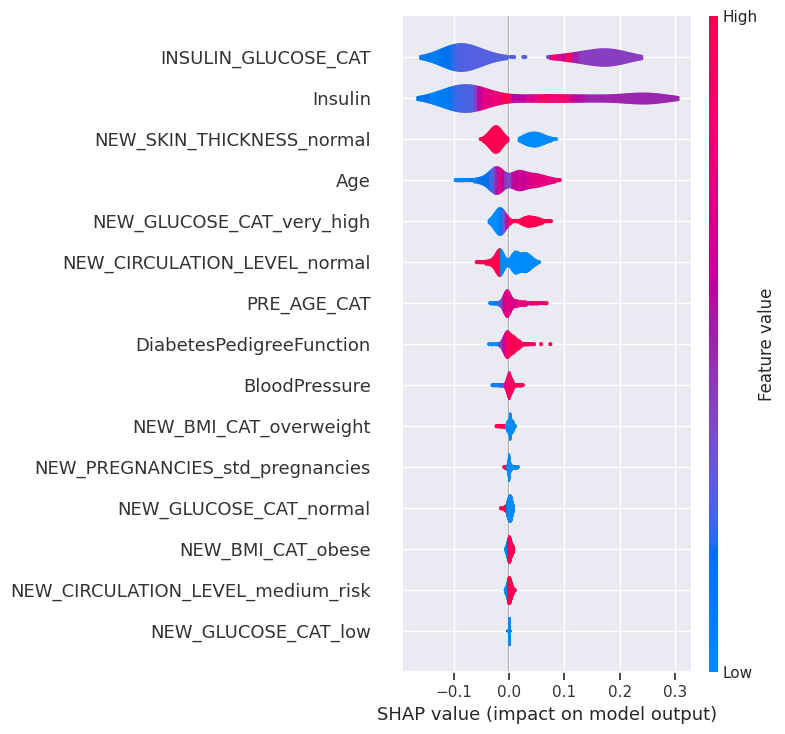

In [67]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train,
                  features = X_train.values,
                  feature_names = X_train.columns.values,
                  plot_type='violin',
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

In [68]:
y_prob = grid_search_rf.best_estimator_.predict_proba(X_test)[:,1]

# Get the location of an example each where porbability of giving thrombolysis
# is <0.01 or >0.99

location_low_probability = np.where(y_prob < 0.1)[0][0]
location_high_probability = np.where(y_prob > 0.9)[0][0]


In [69]:
print(f"Number of elements in y_prob: {len(y_prob)}")
print(f"Number of elements where y_prob < 0.05: {len(np.where(y_prob < 0.08)[0])}")
print(f"Number of elements where y_prob > 0.95: {len(np.where(y_prob > 0.92)[0])}")

Number of elements in y_prob: 154
Number of elements where y_prob < 0.05: 59
Number of elements where y_prob > 0.95: 0


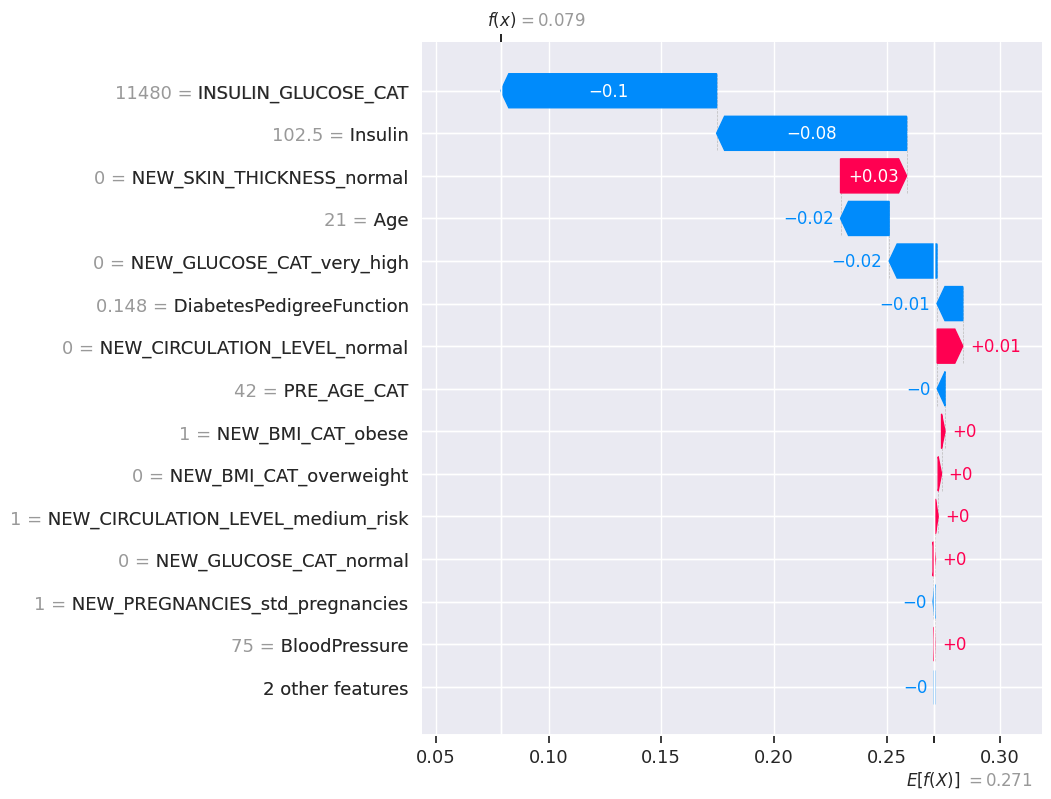

In [70]:
shap.plots.waterfall(shapley_values_test_extended[location_low_probability][:,1],
                     max_display=15)

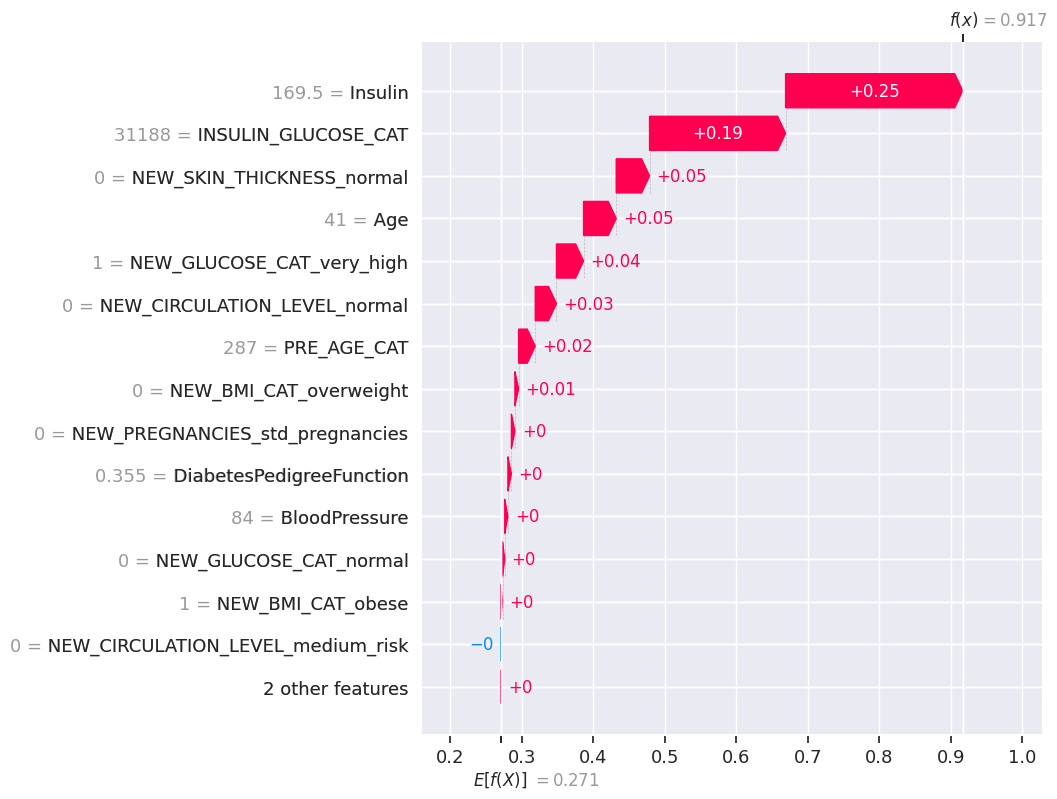

In [71]:
shap.plots.waterfall(shapley_values_test_extended[location_high_probability][:,1],
                     max_display=15)

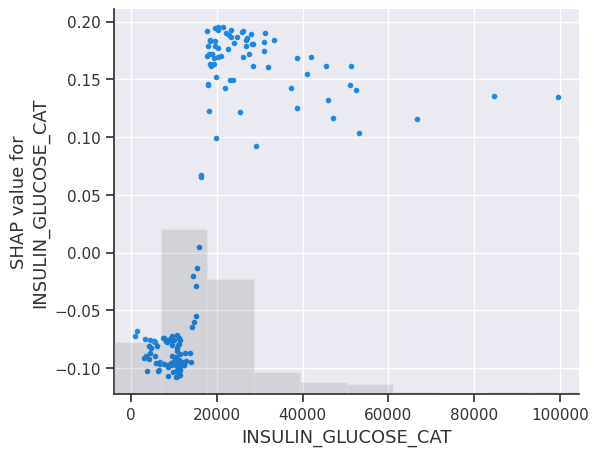

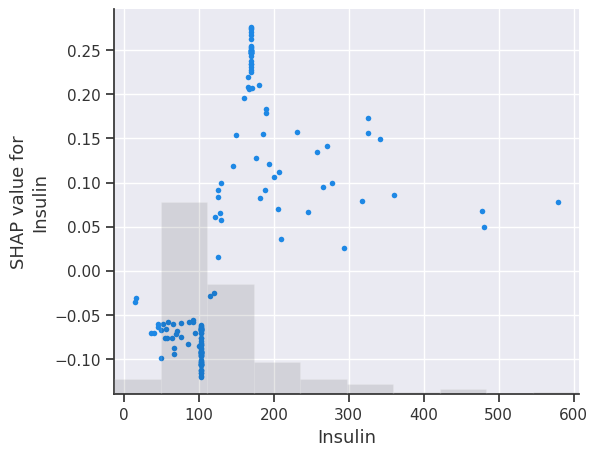

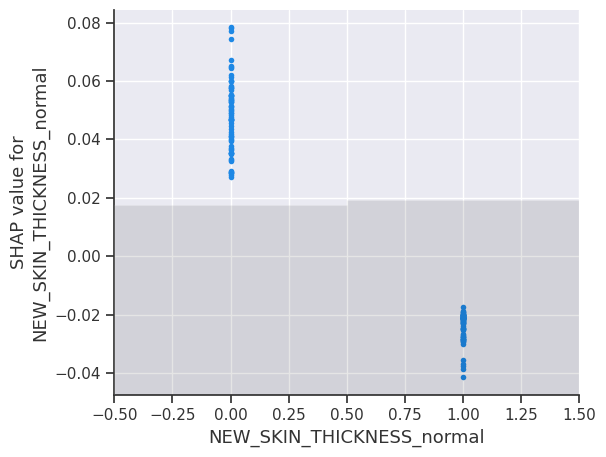

In [72]:
feat_to_show = shapley_top_10[0:3]

for feat in feat_to_show:
    shap.plots.scatter(shapley_values_test_extended[:, feat][:,1], x_jitter=0)

# **LIME**

## **FOR DIABETIC PATIENT**

In [73]:
from lime.lime_tabular import LimeTabularExplainer

# Create explainer
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=['Non-Diabetic', 'Diabetic'],
                                 discretize_continuous=True)

# Choose a sample from the test set for explanation
sample_idx = 0  # Choose the index of the sample you want to explain
sample = X_test.iloc[[sample_idx]]
true_label = y_test.iloc[sample_idx]  # True label of the sample

# Explain the prediction for the sample
explanation = explainer.explain_instance(sample.values[0],
                                         grid_search_rf.predict_proba,
                                         num_features=len(X_train.columns))

# Display explanation
explanation.show_in_notebook()  # Display the explanation in a Jupyter notebook


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## **FOR NON-DIABETIC PATIENT**

In [74]:
from lime.lime_tabular import LimeTabularExplainer

# Create explainer
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=['Non-Diabetic', 'Diabetic'],
                                 discretize_continuous=True)

# Choose a sample from the test set for explanation
sample_idx = 1  # Choose the index of the sample you want to explain
sample = X_test.iloc[[sample_idx]]
true_label = y_test.iloc[sample_idx]  # True label of the sample

# Explain the prediction for the sample
explanation = explainer.explain_instance(sample.values[0],
                                         grid_search_rf.predict_proba,
                                         num_features=len(X_train.columns))

# Display explanation
explanation.show_in_notebook()  # Display the explanation in a Jupyter notebook


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## **FOR ALL THE PATIENTS**

In [38]:
"""
from tqdm.notebook import tqdm

# Create explainer
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns.tolist(),
                                 class_names=['Non-Diabetic', 'Diabetic'],
                                 discretize_continuous=True)

# Loop through the test set samples with tqdm progress bar
for x in tqdm(range(len(X_test)), desc='Explaining samples'):
    sample_idx = x  # Choose the index of the sample you want to explain
    sample = X_test.iloc[[sample_idx]]
    true_label = y_test.iloc[sample_idx]  # True label of the sample

    # Explain the prediction for the sample
    explanation = explainer.explain_instance(sample.values[0],
                                              grid_search_rf.predict_proba,
                                              num_features=len(X_train.columns))

    # Display explanation
    explanation.show_in_notebook()  # Display the explanation in a Jupyter notebook
"""

"\nfrom tqdm.notebook import tqdm\n\n# Create explainer\nexplainer = LimeTabularExplainer(X_train.values,\n                                 feature_names=X_train.columns.tolist(),\n                                 class_names=['Non-Diabetic', 'Diabetic'],\n                                 discretize_continuous=True)\n\n# Loop through the test set samples with tqdm progress bar\nfor x in tqdm(range(len(X_test)), desc='Explaining samples'):\n    sample_idx = x  # Choose the index of the sample you want to explain\n    sample = X_test.iloc[[sample_idx]]\n    true_label = y_test.iloc[sample_idx]  # True label of the sample\n\n    # Explain the prediction for the sample\n    explanation = explainer.explain_instance(sample.values[0],\n                                              grid_search_rf.predict_proba,\n                                              num_features=len(X_train.columns))\n\n    # Display explanation\n    explanation.show_in_notebook()  # Display the explanation in a Jupyte

# **ELI5**

## **EXPLANATION FOR NON-DIABETIC PATIENT**

In [75]:
"""
import eli5
from eli5.sklearn import PermutationImportance



# Fit Permutation Importance to the model
perm = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)

# Display feature importances
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
"""

'\nimport eli5\nfrom eli5.sklearn import PermutationImportance\n\n\n\n# Fit Permutation Importance to the model\nperm = PermutationImportance(rf_model, random_state=42).fit(X_test, y_test)\n\n# Display feature importances\neli5.show_weights(perm, feature_names = X_test.columns.tolist())\n'

In [76]:
import eli5
# Assuming 'grid_search_rf' is your trained Random Forest model
rf_model = grid_search_rf.best_estimator_

In [77]:
instance = X_test.iloc[1] #Explaining the weights for a non-diabetic patient
instance

BloodPressure                           75.000
Insulin                                102.500
DiabetesPedigreeFunction                 0.148
Age                                     21.000
PRE_AGE_CAT                             42.000
INSULIN_GLUCOSE_CAT                  11480.000
NEW_BMI_CAT_obese                        1.000
NEW_BMI_CAT_overweight                   0.000
NEW_BMI_CAT_underweight                  0.000
NEW_GLUCOSE_CAT_low                      0.000
NEW_GLUCOSE_CAT_normal                   0.000
NEW_GLUCOSE_CAT_very_high                0.000
NEW_PREGNANCIES_std_pregnancies          1.000
NEW_SKIN_THICKNESS_normal                0.000
NEW_CIRCULATION_LEVEL_medium_risk        1.000
NEW_CIRCULATION_LEVEL_normal             0.000
Name: 324, dtype: float64

In [78]:
y_test.iloc[1]

0

In [79]:

eli5.explain_prediction(rf_model, instance, target_names = ['Non-Diabetic', 'Diabetic'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without

Explanation(estimator='RandomForestClassifier(max_leaf_nodes=14, n_estimators=400, n_jobs=-1)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target='Non-Diabetic', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.653469055374593, std=None, value=1.0), FeatureWeight(feature='INSULIN_GLUCOSE_CAT', weight=0.13239686721395294, std=None, value=11480.0), FeatureWeight(feature='Insulin', weight=0.12858108527015918, std=None, value=102.5), FeatureWeight(feature='NEW_GLUCOSE_CAT_very_high', weight=0.039785655187148654, std=None, value=0.0), FeatureWeight(feature='Age', weight=0.02674986648148174, std=None, value=21.0), FeatureWeight(feature='DiabetesPedigreeFunction', weight=0.015011786075084266, std=None, value=0.148), FeatureWeight(feature='PRE_AGE_CAT', weight=0.010630282189886998, std=None, value=42.0), FeatureWeight(feature='NEW_PREGNANCIES_std_pregnancies', weight=0.0023546212027965134, std=None, value=1.0), FeatureWeight(feature='BloodPressure', weight=0.00027271034559936207, std=None, value=75.0)], neg=[FeatureWeight(feature='NEW_SKIN_THICKNESS_normal', weight=-0.05063051591088343, std=None, value=0.0), FeatureWeight(feature='NEW_CIRCULATION_LEVEL_normal', weight=-0.02686510373073251, std=None, value=0.0), FeatureWeight(feature='NEW_GLUCOSE_CAT_normal', weight=-0.006038640746835848, std=None, value=0.0), FeatureWeight(feature='NEW_BMI_CAT_obese', weight=-0.0018403150110705177, std=None, value=1.0), FeatureWeight(feature='NEW_BMI_CAT_overweight', weight=-0.0014592050315901548, std=None, value=0.0), FeatureWeight(feature='NEW_CIRCULATION_LEVEL_medium_risk', weight=-0.001278050069860541, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9211400988397298, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

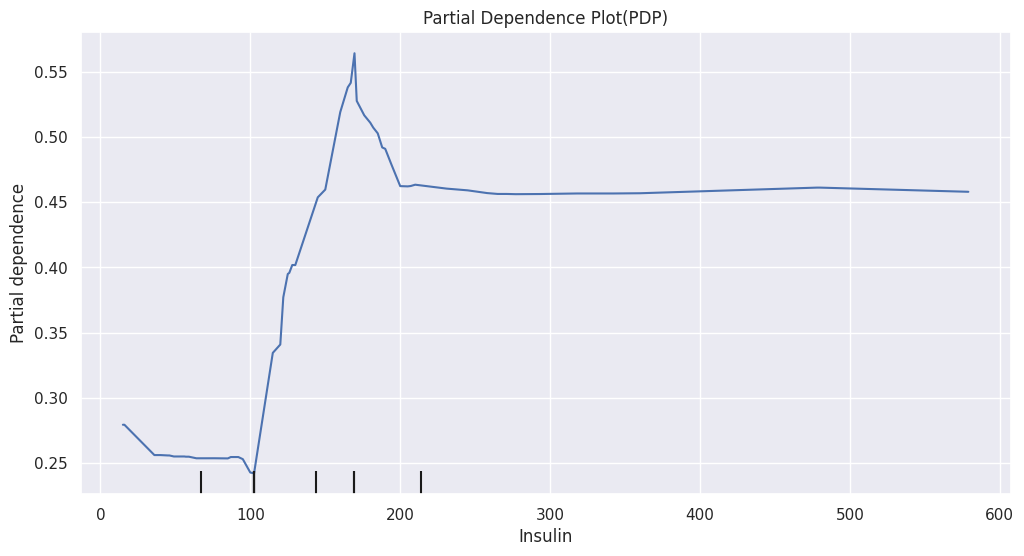

In [80]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title("Partial Dependence Plot(PDP)")
PartialDependenceDisplay.from_estimator(rf_model, X_test, features = ["Insulin"], feature_names = X_train.columns.tolist(), ax = ax);

## **EXPLANATION FOR DIABETIC PATIENT**

In [81]:
"""

from eli5.sklearn import PermutationImportance

# Fit the permutation importance on the trained model
perm = PermutationImportance(grid_search_rf.best_estimator_).fit(X_test, y_test)

# Display feature importances
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
"""

'\n\nfrom eli5.sklearn import PermutationImportance\n\n# Fit the permutation importance on the trained model\nperm = PermutationImportance(grid_search_rf.best_estimator_).fit(X_test, y_test)\n\n# Display feature importances\neli5.show_weights(perm, feature_names = X_test.columns.tolist())\n'

In [82]:
import eli5
# Assuming 'grid_search_rf' is your trained Random Forest model
rf_model = grid_search_rf.best_estimator_

In [83]:
instance1 = X_test.iloc[0] #Explaining the weights for a non-diabetic patient
instance1

BloodPressure                           58.00
Insulin                                190.00
DiabetesPedigreeFunction                 0.43
Age                                     43.00
PRE_AGE_CAT                            258.00
INSULIN_GLUCOSE_CAT                  18620.00
NEW_BMI_CAT_obese                        1.00
NEW_BMI_CAT_overweight                   0.00
NEW_BMI_CAT_underweight                  0.00
NEW_GLUCOSE_CAT_low                      0.00
NEW_GLUCOSE_CAT_normal                   1.00
NEW_GLUCOSE_CAT_very_high                0.00
NEW_PREGNANCIES_std_pregnancies          0.00
NEW_SKIN_THICKNESS_normal                0.00
NEW_CIRCULATION_LEVEL_medium_risk        1.00
NEW_CIRCULATION_LEVEL_normal             0.00
Name: 668, dtype: float64

In [84]:
y_test.iloc[0]

0

In [85]:

eli5.explain_prediction(rf_model, instance, target_names = ['Non-Diabetic', 'Diabetic'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without

Explanation(estimator='RandomForestClassifier(max_leaf_nodes=14, n_estimators=400, n_jobs=-1)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target='Non-Diabetic', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.653469055374593, std=None, value=1.0), FeatureWeight(feature='INSULIN_GLUCOSE_CAT', weight=0.13239686721395294, std=None, value=11480.0), FeatureWeight(feature='Insulin', weight=0.12858108527015918, std=None, value=102.5), FeatureWeight(feature='NEW_GLUCOSE_CAT_very_high', weight=0.039785655187148654, std=None, value=0.0), FeatureWeight(feature='Age', weight=0.02674986648148174, std=None, value=21.0), FeatureWeight(feature='DiabetesPedigreeFunction', weight=0.015011786075084266, std=None, value=0.148), FeatureWeight(feature='PRE_AGE_CAT', weight=0.010630282189886998, std=None, value=42.0), FeatureWeight(feature='NEW_PREGNANCIES_std_pregnancies', weight=0.0023546212027965134, std=None, value=1.0), FeatureWeight(feature='BloodPressure', weight=0.00027271034559936207, std=None, value=75.0)], neg=[FeatureWeight(feature='NEW_SKIN_THICKNESS_normal', weight=-0.05063051591088343, std=None, value=0.0), FeatureWeight(feature='NEW_CIRCULATION_LEVEL_normal', weight=-0.02686510373073251, std=None, value=0.0), FeatureWeight(feature='NEW_GLUCOSE_CAT_normal', weight=-0.006038640746835848, std=None, value=0.0), FeatureWeight(feature='NEW_BMI_CAT_obese', weight=-0.0018403150110705177, std=None, value=1.0), FeatureWeight(feature='NEW_BMI_CAT_overweight', weight=-0.0014592050315901548, std=None, value=0.0), FeatureWeight(feature='NEW_CIRCULATION_LEVEL_medium_risk', weight=-0.001278050069860541, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9211400988397298, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

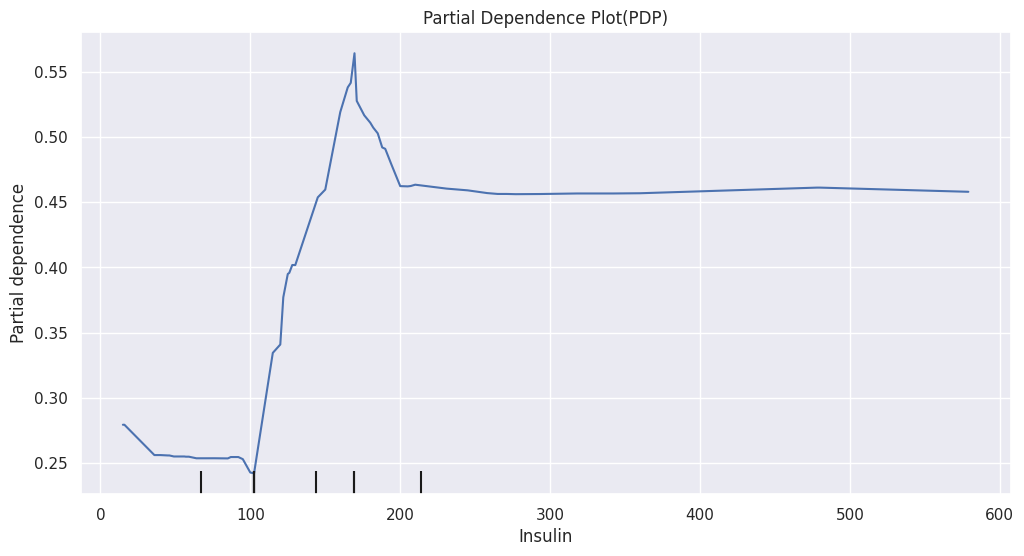

In [86]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title("Partial Dependence Plot(PDP)")
PartialDependenceDisplay.from_estimator(rf_model, X_test, features = ["Insulin"], feature_names = X_train.columns.tolist(), ax = ax);